In [54]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import StackingClassifier, VotingClassifier

from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC
from imblearn.pipeline import Pipeline as imb_pipeline
from category_encoders.target_encoder import TargetEncoder

import lightgbm as lgb
import xgboost as xgb
import optuna
from optuna.integration import LightGBMPruningCallback

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

%matplotlib inline

# User Defined functions

In [63]:
def plot_cf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

# Read Data

In [2]:
train_data = pd.read_pickle('./data/train_file_eng.pkl')

In [4]:
train_data.shape

(32910, 17)

In [3]:
train_data.head(1)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,previous,poutcome,y,y_encoded,quarter
0,49,blue-collar,married,basic.9y,unknown,no,no,cellular,nov,wed,227,4,0,nonexistent,no,0,q4


In [5]:
feature_set = ['age', 'job', 'education', 'default',
               'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
               'poutcome', 'quarter']

cat_features = ['job', 'education', 'default',
                'contact', 'month', 'day_of_week', 'poutcome', 'quarter']

num_features = ['age', 'duration', 'campaign', 'previous']

In [6]:
for col_name in cat_features:
    train_data[col_name] = train_data[col_name].astype('category')

# Train Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_data[feature_set], train_data.y_encoded, random_state=24, test_size=0.2)

In [8]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [9]:
X_train.shape, X_test.shape

((26328, 12), (6582, 12))

# Random Oversampling

In [123]:
sampler = RandomOverSampler(sampling_strategy='auto', random_state=24)
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

# LightGBM

In [22]:
lgb_hyperparam_dict = {
                     'colsample_bytree': 0.7029693318019654,
                     'learning_rate': 0.11333569688388861,
                     'max_depth': 7,
                     'min_child_samples': 80,
                     'n_estimators': 100,
                     'num_leaves': 19,
                     'reg_alpha': 4,
                     'reg_lambda': 0,
                     'params_subsample': 0.5170860303134346,
                      }

In [23]:
lgb_model = lgb.LGBMClassifier(objective="binary",
                           subsample_freq=1,
                           verbosity=-1,
                           random_state=24,
                           n_jobs=4, **lgb_hyperparam_dict)

lgb_model.fit(X_train_balanced, y_train_balanced, verbose=-1)

[LightGBM] [Warning] Unknown parameter: params_subsample


LGBMClassifier(colsample_bytree=0.7029693318019654,
               learning_rate=0.11333569688388861, max_depth=7,
               min_child_samples=80, n_jobs=4, num_leaves=19,
               objective='binary', params_subsample=0.5170860303134346,
               random_state=24, reg_alpha=4, reg_lambda=0, subsample_freq=1,
               verbosity=-1)

In [72]:
y_preds = lgb_model.predict_proba(X_test)
y_preds = [i[1] for i in y_preds]
score = roc_auc_score(y_test, y_preds)

print('AUC Score of Best LightGBM Model on Test Set:', round(score, 4))

AUC Score of Best LightGBM Model on Test Set: 0.9278


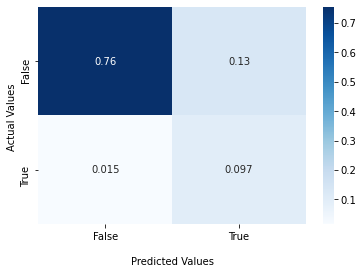

In [64]:
y_preds2 = lgb_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_preds2, normalize='all')
plot_cf(cf_matrix)

# XGBoost

In [127]:
xgb_hyperparam_dict = {
                     'colsample_bytree': 0.7310016759193707,
                     'learning_rate': 0.01085683932685544,
                     'max_depth': 7,
                     'min_child_weight': 20,
                     'n_estimators': 1000,
                     'reg_alpha': 3,
                     'reg_lambda': 1,
                     'subsample': 0.5009186963118293,
                      }

In [128]:
cat_transformer = Pipeline(steps=[('encoder', TargetEncoder(min_samples_leaf=100, smoothing=5))])
num_transformer = Pipeline(steps=[('identity', FunctionTransformer(func = None))])

preprocessor = ColumnTransformer(transformers=[
                                                ('num_trans', num_transformer, num_features),
                                                ('cat_trans', cat_transformer, cat_features)
                                            ],
                                remainder='drop')

model = xgb.XGBClassifier(objective="binary:logistic",
                          verbosity=0,
                          random_state=24,
                          tree_method="hist",
                          enable_categorical=False,
                          n_jobs=4, **xgb_hyperparam_dict)

xgb_model = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)]
)

xgb_model.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('identity',
                                                                   FunctionTransformer())]),
                                                  ['age', 'duration',
                                                   'campaign', 'previous']),
                                                 ('cat_trans',
                                                  Pipeline(steps=[('encoder',
                                                                   TargetEncoder(min_samples_leaf=100,
                                                                                 smoothing=5.0))]),
                                                  ['job', 'education',
                                                   'default', 'contact',
                                                   'month', 'day_of_week',
                      

In [129]:
y_preds = xgb_model.predict_proba(X_test)
y_preds = [i[1] for i in y_preds]
score = roc_auc_score(y_test, y_preds)

print('AUC Score of Best XGBoost Model on Test Set:', round(score, 4))

AUC Score of Best XGBoost Model on Test Set: 0.9291


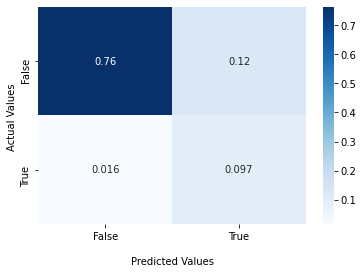

In [130]:
y_preds2 = xgb_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_preds2, normalize='all')
plot_cf(cf_matrix)

# Stacking

In [56]:
estimators = [
    ('lgb', lgb_model),
    ('xgb', xgb_model)
]

clf = StackingClassifier(estimators=estimators,
                         final_estimator=LogisticRegression(),
                         cv=5,
                         stack_method='predict_proba',
                         n_jobs=-1,
                         verbose=3,
                        )

clf.fit(X_train_balanced, y_train_balanced)

StackingClassifier(cv=5,
                   estimators=[('lgb',
                                LGBMClassifier(colsample_bytree=0.7029693318019654,
                                               learning_rate=0.11333569688388861,
                                               max_depth=7,
                                               min_child_samples=80, n_jobs=4,
                                               num_leaves=19,
                                               objective='binary',
                                               params_subsample=0.5170860303134346,
                                               random_state=24, reg_alpha=4,
                                               reg_lambda=0, subsample_freq=1,
                                               verbosity=-1)),
                               ('xgb',
                                Pipeline(steps=[('preprocessor'...
                                                               min_child_weight=20,
         

In [73]:
y_preds = clf.predict_proba(X_test)
y_preds = [i[1] for i in y_preds]
score = roc_auc_score(y_test, y_preds)

print('AUC Score of Stacking Ensemble Model on Test Set:', round(score, 4))

AUC Score of Stacking Ensemble Model on Test Set: 0.9292


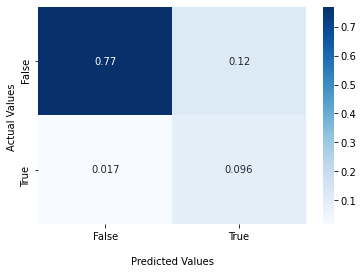

In [66]:
y_preds2 = clf.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_preds2, normalize='all')
plot_cf(cf_matrix)

# Soft Voting

In [68]:
estimators = [
    ('lgb', lgb_model),
    ('xgb', xgb_model)
]

clf_voting = VotingClassifier(estimators=estimators,
                              voting='soft',
                              n_jobs=-1)

clf_voting.fit(X_train_balanced, y_train_balanced)

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(colsample_bytree=0.7029693318019654,
                                             learning_rate=0.11333569688388861,
                                             max_depth=7, min_child_samples=80,
                                             n_jobs=4, num_leaves=19,
                                             objective='binary',
                                             params_subsample=0.5170860303134346,
                                             random_state=24, reg_alpha=4,
                                             reg_lambda=0, subsample_freq=1,
                                             verbosity=-1)),
                             ('xgb',
                              Pipeline(steps=[('preprocessor',
                                               Column...
                                                             learning_rate=0.01085683932685544,
                                      

In [74]:
y_preds = clf_voting.predict_proba(X_test)
y_preds = [i[1] for i in y_preds]
score = roc_auc_score(y_test, y_preds)

print('AUC Score of Voting Ensemble Model on Test Set:', round(score, 4))

AUC Score of Voting Ensemble Model on Test Set: 0.929


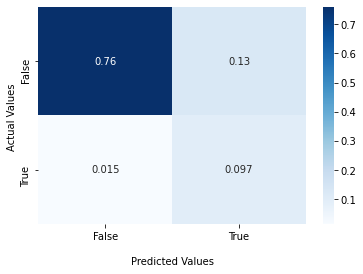

In [70]:
y_preds2 = clf_voting.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_preds2, normalize='all')
plot_cf(cf_matrix)

# Learning Curve Check for Final XGBoost Model

In [ ]:
train_scores, test_scores = [], []
for train_size in range(1000, len(X_train), 1000):

    sampler = RandomOverSampler(sampling_strategy='auto', random_state=24)
    X_train_balanced, y_train_balanced = sampler.fit_resample(X_train.iloc[:train_size], y_train.iloc[:train_size])

    xgb_hyperparam_dict = {
                         'colsample_bytree': 0.7310016759193707,
                         'learning_rate': 0.01085683932685544,
                         'max_depth': 7,
                         'min_child_weight': 20,
                         'n_estimators': 1000,
                         'reg_alpha': 3,
                         'reg_lambda': 1,
                         'subsample': 0.5009186963118293,
                          }

    cat_transformer = Pipeline(steps=[('encoder', TargetEncoder(min_samples_leaf=100, smoothing=5))])
    num_transformer = Pipeline(steps=[('identity', FunctionTransformer(func = None))])

    preprocessor = ColumnTransformer(transformers=[
                                                    ('num_trans', num_transformer, num_features),
                                                    ('cat_trans', cat_transformer, cat_features)
                                                ],
                                    remainder='drop')

    model = xgb.XGBClassifier(objective="binary:logistic",
                              verbosity=0,
                              random_state=24,
                              tree_method="hist",
                              enable_categorical=False,
                              n_jobs=4, **xgb_hyperparam_dict)

    xgb_model_lc = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )

    xgb_model_lc.fit(X_train_balanced, y_train_balanced)

    y_preds_train = xgb_model_lc.predict_proba(X_train_balanced)[::,1]
    y_preds_test = xgb_model_lc.predict_proba(X_test)[::,1]

    score_train = roc_auc_score(y_train_balanced, y_preds_train)
    score_test = roc_auc_score(y_test, y_preds_test)
    train_scores.append(score_train)
    test_scores.append(score_test)

In [106]:
train_scores = [1] + train_scores
test_scores = [0.5] + test_scores

learning_curve_df = pd.DataFrame(
                                {'training_size': [1]+[i for i in range(1000, len(X_train), 1000)],
                                 'training_score': train_scores,
                                 'test_score': test_scores
                                })

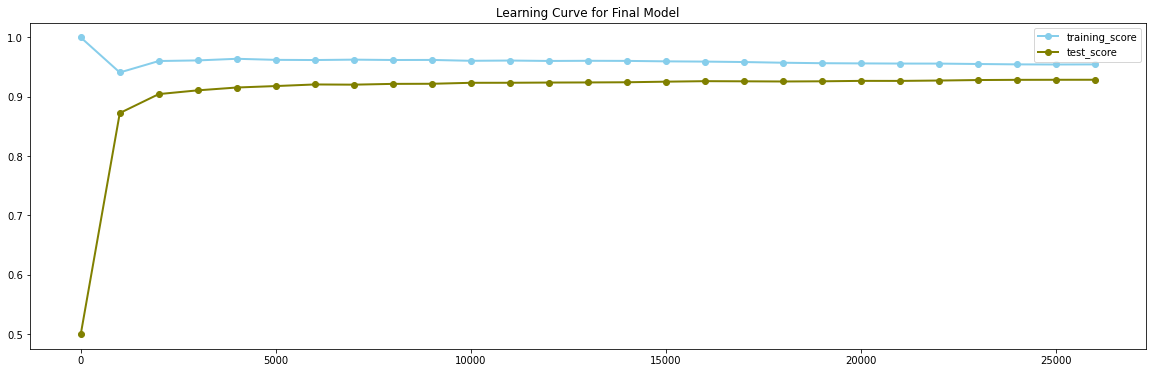

In [116]:
plt.figure(figsize=(20,6))
plt.plot('training_size', 'training_score', data=learning_curve_df, marker='o', color='skyblue', linewidth=2, label='training_score')
plt.plot('training_size', 'test_score', data=learning_curve_df, marker='o', color='olive', linewidth=2, label='test_score')
plt.title('Learning Curve for Final Model')
plt.legend()
plt.show()